In [1]:
import lettuce as lt
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
import csv
from argparse import ArgumentParser, ArgumentDefaultsHelpFormatter


In [2]:
parser = ArgumentParser(formatter_class=ArgumentDefaultsHelpFormatter)
parser.add_argument("--vtkdir", type=str, help="name base of vtk files - they are usually in a vtk-subdirectory!", default="./output/")
parser.add_argument("--csvdir", type=str, default="./output/")
parser.add_argument("--resolution", type=int, default=16)
parser.add_argument("--nout", type=int, default=100)
parser.add_argument("--nvtk", type=int, default=200)
parser.add_argument("--tmax", type=int, default=10)
parser.add_argument("--Re", type=int, default=100)
parser.add_argument("--collision_operator", type=str, default="BGK")
args, unknown = parser.parse_known_args()
args = vars(args)
print("ICH FUNKTIONIERE MIT PULLEN")
Re=args["Re"]
basedir = args["vtkdir"]
csvdir = args["csvdir"]
res = args["resolution"]
nout = args["nout"]
nvtk = args["nvtk"]
tmax = args["tmax"]
collision_operator = args["collision_operator"]



ICH FUNKTIONIERE MIT PULLEN


In [3]:
lattice = lt.Lattice(lt.D3Q27, device = "cpu", dtype=torch.float32)
flow = lt.SuperReducedTaylorGreenVortex3D(resolution=res, reynolds_number=Re, mach_number=0.05, lattice=lattice)
print(flow.units.convert_time_to_lu(tmax))


# Konstruktion des Funktionsnamens
function_name = f"{collision_operator}Collision"

if collision_operator == "BGK":
    collision=lt.BGKCollision(lattice, tau=flow.units.relaxation_parameter_lu)
elif collision_operator == "KBC":
    collision=lt.KBCCollision3D(lattice, tau=flow.units.relaxation_parameter_lu)

print(flow.units.relaxation_parameter_lu)
streaming = lt.StandardStreaming(lattice)
simulation = lt.SimulationReducedTGV(flow=flow, lattice=lattice, collision=collision, streaming=streaming)


3528.504930699469
0.5088212623267486


In [4]:
interval_vtk=int((flow.units.convert_time_to_lu(tmax))/1)
interval_out=int((flow.units.convert_time_to_lu(tmax))/500)
Energy = lt.IncompressibleKineticEnergy(lattice, flow)
Dissipation_TGV=lt.Dissipation_TGV(lattice, flow)
reporter = lt.ObservableReporter(Energy, interval=interval_out, out=None)
reporter2= lt.ObservableReporter(Dissipation_TGV, interval=interval_out, out=None)
simulation.reporters.append(reporter)
simulation.reporters.append(reporter2)
simulation.reporters.append(lt.VTKReporter(lattice, flow, interval=interval_vtk, filename_base=basedir+"out"))

steps     time     IncompressibleKineticEnergy
steps     time     Dissipation_TGV


In [5]:
simulation.initialize_f_neq()
steps = int(flow.units.convert_time_to_lu(tmax))
mlups = simulation.step(num_steps=steps)
#print("Performance in MLUPS:", mlups)


In [6]:
energy = np.array(simulation.reporters[0].out)
dissipation = np.array(simulation.reporters[1].out)
dEdt=np.zeros(len(energy[:,2]))
dt=energy[1,1]-energy[0,1]
nmax=len(energy[:,2])
print(nmax,dt)
for i in range(len(energy[:,2])):
    if i == 0:
        dEdt[i] = (energy[1,2] - energy[0,2]) / dt
    elif i == 1:
        dEdt[i] = (energy[2,2] - energy[0,2]) / 2/dt
    elif i == 2:
        dEdt[i] = (1/12*energy[0,2] - 2/3*energy[1,2] + 2/3*energy[3,2] - 1/12*energy[4,2]) / dt
    elif i >= (nmax-3):
        if i == (nmax-3):
            dEdt[i] = (1/12*energy[nmax-5,2] - 2/3*energy[nmax-4,2] + 2/3*energy[nmax-2,2] - 1/12*energy[nmax-1,2]) / dt
        elif i == (nmax-2):
            dEdt[i] = (energy[nmax-1,2] - energy[nmax-3,2]) /2/ dt
        elif i == (nmax-1):
            dEdt[i] = (energy[nmax-1,2] - energy[nmax-2,2]) /dt
    elif i < (nmax-3):
        dEdt[i] = (-1/60*energy[i-3,2] + 3/20*energy[i-2,2] - 3/4*energy[i-1,2] + 3/4*energy[i+1,2] - 3/20*energy[i+2,2] + 1/60*energy[i+3,2]) / dt
#dissipationEkin=np.array([energy[:,1],-1/(np.pi*2)**3*np.gradient(energy[:,2],energy[:,1])])

dissipationEkin=np.array([energy[:,1],-dEdt/(np.pi*0.5)**3])

dissipationEns=np.array([dissipation[:,1],1/(0.5*np.pi)**3*dissipation[:,3]])
dissipationSij=np.array([dissipation[:,1],dissipation[:,2]])

with open(csvdir + 'DissipationEkin.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(dissipationEkin)
with open(csvdir + 'DissipationEnstrophy.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(dissipationEns)
with open(csvdir + 'DissipationSij.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(dissipationSij)

505 0.01983843054631176


[31.0062809  30.97751045 30.93684578 30.90089417 30.86393356 30.82723045
 30.79123878 30.75302315 30.71780586 30.68029404 30.64393616 30.60717392
 30.57063103 30.53406906 30.49723053 30.46086693 30.42407799 30.38751602
 30.3508358  30.31420326 30.27754402 30.24086189 30.20422554 30.16747856
 30.13072586 30.09393311 30.05715752 30.02034378 29.98348045 29.9465847
 29.90964699 29.87267303 29.83564568 29.79856491 29.76143074 29.72426033
 29.68703842 29.64975929 29.6124115  29.57499313 29.53751564 29.49996376
 29.46232605 29.42463684 29.38689423 29.34907341 29.31114006 29.27310944
 29.2349987  29.19682312 29.15856934 29.12020111 29.08172989 29.04317284
 29.00453377 28.96577835 28.92690086 28.88790321 28.84881401 28.80962563
 28.77033615 28.73091316 28.69137001 28.65170097 28.61190033 28.57196999
 28.53192139 28.49175644 28.45145988 28.41101837 28.37042809 28.32970047
 28.28884506 28.24784279 28.20668411 28.16538239 28.12394524 28.08237076
 28.04063225 27.99872017 27.95664024 27.91440773 27.

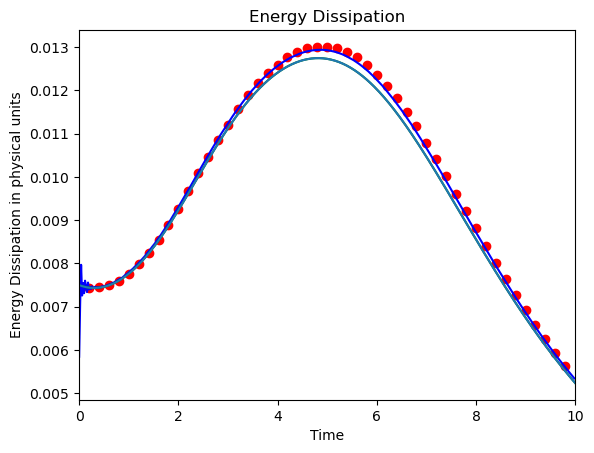

In [7]:
csv_file_path = '/home/ben/Schreibtisch/Enstropy Brachet/Brachet/Brachet_1983_tgv3d_enstrophy_Re100.csv'

# Daten aus der CSV-Datei lesen
csv_data = []
with open(csv_file_path, 'r') as file:
    csv_reader = csv.reader(file, delimiter=';')
    for row in csv_reader:
        csv_data.append(row)

csv_data = np.array(csv_data, dtype=float)
print(64*energy[:,2])

plt.plot(dissipationEkin[0,:],dissipationEkin[1,:],color = 'blue')
plt.plot(dissipationEns[0,:],dissipationEns[1,:], color = 'green')
plt.xlim(0,10)
plt.plot(dissipationSij[0,:],dissipationSij[1,:])
plt.scatter(csv_data[:, 0], csv_data[:, 1], color='red', label='CSV Data')
#plt.plot(energy[:,1],energy[:,2]*64)
plt.title('Energy Dissipation')
plt.xlabel('Time')
plt.ylabel('Energy Dissipation in physical units')
plt.show()